# Techno-Economic Analysis (TEA) <a class="anchor" id="top"></a>

* **Prepared by:**
    
    - [Yalin Li](https://qsdsan.readthedocs.io/en/latest/CONTRIBUTING.html)

* **Covered topics:**

    - [1. Using the TEA class](#s1)
    - [2. Developing your own TEA subclass](#s2)
    
- **Video demo:**

    - [Hannah Lohman](https://qsdsan.readthedocs.io/en/latest/CONTRIBUTING.html)

To run tutorials in your browser, go to this [Binder page](https://mybinder.org/v2/gh/QSD-Group/QSDsan-env/main?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252FQSD-group%252FQSDsan%26urlpath%3Dtree%252FQSDsan%252Fdocs%252Fsource%252Ftutorials%26branch%3Dmain).

You can also watch a video demo on [YouTube](https://youtu.be/v3qNNZypTKY) (subscriptions & likes appreciated!).

In [1]:
import qsdsan as qs
print(f'This tutorial was made with qsdsan v{qs.__version__}.')

This tutorial was made with qsdsan v1.2.5.


## 1. Using the `TEA` class <a class="anchor" id="s1"></a>

TEA can be performed through subclasses of the `TEA` class in `biosteam`, but you cannot just use the `TEA` class (it's an abstract class, see later part of this tutorial for details).

In `qsdsan`, there is a `TEA` class (used to be called `SimpleTEA` but now the `Simple` part is dropped since it's not a "simple" version of fewer functions) that is based on the `TEA` class of `biosteam`.

You can directly use the default `qsdsan.TEA` class, and you can make your own `TEA` subclass if you want to include customize cost calculations (see [Section 2](#s2) of this tutorial).

---

### Note

In `qsdsan.TEA`, there are two attributes related to annual capital cost: `annualized_equipment_cost` and `annualized_CAPEX`.

`annualized_equipment_cost` is calculated as the sum of annualized capital cost of each equipment. The annualized capital cost of each equipment is calculated as:

`annualized_equipment_cost` = $$\frac{installed\ equipment\ cost*r}{(1-(1+r)^{-lifetime})}$$

where `r` is the discount rate, and `lifetime` will be:
- lifetime of the equipment (if provided)
- lifetime of the unit (if provided)
- lifetime given in initializing the `TEA` instance

This becomes optimistic when the TEA year is not divisible by the lifetime of the equipment (e.g., you are doing a TEA for 10 years but the equipment lifetime is 8 years). Using this method, you are implicitly assuming that you can savage the remaining value of the equipment.

On the other hand, `annualized_CAPEX` uses the annualized net present value (NPV) calculated from the cash flow analysis to get the annualized capital cost.

$$
annualized\ NPV = \frac{NPV*r}{(1-(1+r)^{-lifetime})}
$$

and the lifetime would be the lifetime of the TEA (i.e., the one provided when initializing the `qsdsan.TEA` instance).

So

`annualized_CAPEX` = $$annual\ net\ earning - annualized\ NPV$$

Additionally, there is equivalent annual cost (EAC) calculated as

$$
EAC = annual\ operating\ cost + annualized\ CAPEX
$$

In this method, no savage value is assumed for the equipment.

If unsure, it is always best to look at the [source code](https://github.com/QSD-Group/QSDsan/blob/main/qsdsan/_tea.py) and determine what is right for your system.

---

C:\Users\Yalin\anaconda3\envs\bq\lib\site-packages\qsdsan\_sanstream.py:67: RuntimeWarning: <WasteStream: flushing_water> has been replaced in registry
  super().__init__(ID=ID, flow=flow, phase=phase, T=T, P=P,


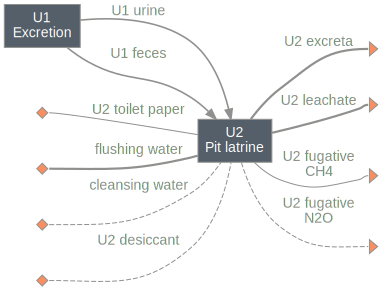

In [2]:
# Let use an example to illustrate this,
# here I'm using some modules from `exposan`
import biosteam as bst
from exposan import bwaise as bw
bw.load() # this loads the components and LCA needed objects
su = qs.sanunits

# Let's assume that the water costs 0.1 USD/kg,
# you can directly adds the cost of chemicals when initializing it 
flushing_water = qs.WasteStream('flushing_water', price=0.1)
cleansing_water = qs.WasteStream('cleansing_water', price=0.1)

U1 = su.Excretion('U1', outs=('U1_urine', 'U1_feces'))
U2 = su.PitLatrine('U2', ins=(U1-0, U1-1, 'U2_toilet_paper', flushing_water,
                              cleansing_water, 'U2_desiccant'),
                   outs=('U2_excreta', 'U2_leachate', 'U2_fugative_CH4', 'U2_fugative_N2O'),
                   N_user=4, N_toilet=2,
                   decay_k_COD=3, decay_k_N=3, max_CH4_emission=0.25)
sys1 = qs.System('sys1', path=(U1, U2))
sys1.simulate()
sys1.diagram()

In [3]:
#  There is no costs associated with the Excretion unit
print(U1.results())

Excretion              Units  U1
Total purchase cost      USD   0
Utility cost          USD/hr NaN
Additional OPEX       USD/hr   0


In [4]:
# But the PitLatrine unit has capital and operating costs
print(U2.results())

Pit latrine                                      Units       U2
Design              Number of users per toilet                4
                    Parallel toilets                          2
                    Emptying period                 yr      0.8
                    Single pit volume               m3     3.66
                    Single pit area                 m2      0.8
                    Single pit depth                 m     4.57
                    Cement                          kg  1.4e+03
                    Sand                            kg 6.34e+03
                    Gravel                          kg 2.56e+03
                    Brick                           kg      454
                    Plastic                         kg     20.2
                    Steel                           kg     67.2
                    Wood                            m3     0.38
                    Excavation                      m3     7.31
Purchase cost       Total toilets       

In [5]:
# With some assumptions, we can calculate costs associated with this system
tea1 = qs.TEA(system=sys1, discount_rate=0.05, lifetime=10)
tea1.show()

TEA: sys1
NPV  : -4,642 USD at 5.0% discount rate


In [6]:
# These values are stored as attributes so you can easily access,
# note that the `Sales` part does not consider income tax
c = qs.currency
for attr in ('NPV', 'EAC', 'CAPEX', 'AOC', 'sales', 'net_earnings'):
    uom = c if attr in ('NPV', 'CAPEX') else (c+('/yr'))
    print(f'{attr} is {getattr(tea1, attr):,.0f} {uom}')

NPV is -4,642 USD
EAC is 601 USD/yr
CAPEX is 898 USD
AOC is 410 USD/yr
sales is 0 USD/yr
net_earnings is -410 USD/yr


In [7]:
# You can generate a report that contains the system flows, designs, and TEA results,
# the report will be saved to where this Jupyter Notebook is saved,
# if you want to save it somewhere else, you can include the path `file='some/where/else/sys1.xlsx'`
# sys1.save_report(file='sys1.xlsx')

## 2. Developing your own `TEA` subclass <a class="anchor" id="s2"></a>

But you may need to consider additional cost items when doing TEA, to do so, you can make your own subclasses of `biosteam.TEA` or `qsdsan.TEA` (`qsdsan.TEA` is a subclass of `biosteam.TEA` with some more assumptions, so you should decide which class to base on according to your needs).

For making subclasses of `TEA`, you can check out this [tutorial](https://biosteam.readthedocs.io/en/latest/tutorial/Techno-economic_analysis.html) in BioSTEAM's documentation, but since you have learned how to make a subclass (see the advanced [tutorial](https://github.com/QSD-Group/QSDsan/blob/main/docs/source/tutorials/5_SanUnit_advanced.ipynb) on SanUnit if you are not sure), let's go through a simple example to create a subclass of `TEA`.

To make a usable (i.e., not abstract) new subclass of `TEA`, you need to at least have three methods:

- `_DPI` for calculating direct permanent/property investment using the attribute `installed_equipment_cost` (i.e., the total cost of all equipment).
- `_TDC` for calculating total direct/depreciable cost using value calculated by `_DPI`.
- `_FCI` for calculating fixed capital investment using value calculated by `_TDC`.
- `_FOC` for calculating fixed operating cost using value calculated by `_FCI`.

In [8]:
# So the following code will trigger an error so it does have any of the needed methods

# class BadTEA(bst.TEA):
#    pass

Then let's assume that:

1. You need to buy some additional liners so that leachate from the pit latrines won't be directly discharged to the environment, and you want to calculate that as 15% of the total installed equipment cost.

    - Since excretion doesn't have a capital cost, the total installed equipment cost of the system equals that of the pit latrines).
    
2. You want to include a 10% contingency of the direct cost. 
3. You have to pay a 5% property tax on the pit latrine.
4. You need to pay $100 USD/yr in labor to clean the pit latrine.

In [9]:
# So we can write the new class like

from random import random
class NewTEA(bst.TEA):
    def __init__(self, system, IRR, # this is the discount rate
                 duration, # a tuple of (start, end) year of the system
                 depreciation, # depreciation schedule
                 income_tax, # note that (understandably) this only applies to `net_earnings`
                 operating_days, # how many days the system is operated per year
                 # When provided, lang_factor is used to calculate FCI based on
                 # the purchase cost (rather than summing update the installed cost
                 # of all equipment, which is calculated from the bare module factors)
                 lang_factor,
                 # New parameters
                 liner_frac=0.15, contingency=0.1, property_tax=0.05,
                 annual_labor=100):
        # `super()` is `bst.TEA`
        super().__init__(system, IRR, duration, depreciation, income_tax,
                         operating_days, lang_factor,
                         # Assume construction can be done within 1 year
                         construction_schedule=(1,),
                         # Assume no startup period
                         startup_months=0, startup_FOCfrac=0,
                         startup_VOCfrac=0, startup_salesfrac=0,
                         # Assume no financing
                         finance_interest=0, finance_years=0, finance_fraction=0,
                         # Assume no working capital
                         WC_over_FCI=0)
        self.liner_frac = liner_frac
        self.contingency = contingency
        self.property_tax = property_tax
        self.annual_labor = annual_labor

    # Adding the liner cost
    def _DPI(self, installed_equipment_cost):
        return installed_equipment_cost*(1+self.liner_frac)
    
    # Adding the contingency
    def _TDC(self, DPI):
        return DPI*(1+self.contingency)
    
    # Directly return TDC since there is no additional cost
    def _FCI(self, TDC):
        return TDC
    
    # The labor cost and property tax is your fixed operating cost,
    # note that even in the case where FCI is needed,
    # you still need to have FCI as a the method argument
    # otherwise BioSTEAM will raise an error because
    # when it calls _FOC, it always passes FCI as an argument
    def _FOC(self, FCI):
        return self.annual_labor+self.property_tax*FCI
    
    # Of course, you can also change other methods,
    # for example, let's assume that we want to add a 
    # random cost in the variable operating cost each year
    @property
    def VOC(self):
        # The original is just `return self.material_cost+self.utility_cost`
        original_voc = self.material_cost+self.utility_cost
        print(f'Original VOC is {original_voc}.')
        random_voc = 100 * random()
        print(f'Random VOC is {random_voc}.')
        return original_voc + random_voc

Now we are good to try it out!

In [10]:
tea2 = NewTEA(sys1, IRR=0.05, duration=(2021, 2031), depreciation='MACRS7',
              income_tax=0.05, operating_days=365, lang_factor=None, 
              # we do not need to specify again since we've set the default values in the class
              # liner_frac=0.15, contingency=0.1, property_tax=0.05, annual_labor=100
             )

In [11]:
tea2

Original VOC is 365.0000002919999.
Random VOC is 87.31253134353302.
NewTEA: sys1
 NPV: -6,418 USD at 5.0% IRR


In [12]:
# Surely it's a bad idea to use a random cost
# since it changes every time you try to retrieve the value
tea2.VOC

Original VOC is 365.0000002919999.
Random VOC is 32.651031716658096.


397.65103200865804

[Back to top](#top)